In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

import torch
device = torch.device('cpu')


#JAX
import jax
import jax.numpy as jnp

from jax_cosmo.scipy import interpolate as jax_interpolate

# Probably should specify in the outer script, not the inner modules
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

# for Matern kernel with Modified Bessel of the 2nd kind (tfp>=0.17.0-dev20220322)
import tensorflow_probability as tfp


#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)

fig = plt.figure()
#plt.plot()
mpl.style.use('default')
rcParams = {
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "lightgray",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black",
    "legend.facecolor":'lightgray',
    "legend.edgecolor":'black',
    'axes.titlecolor': 'white'}

def set_style():
    global fig
    mpl.style.use('default')
    plt.rcParams.update(rcParams)
    fig.patch.set_alpha(0)

FS = 18 # fontsize


import warnings
warnings.simplefilter("ignore", UserWarning)

def to_date(time_array,offset_date='2000-01-01T00:00:00'):
    return np.array([pd.Timedelta(x,'days').round('d')+pd.Timestamp(offset_date) for x in time_array])

<Figure size 640x480 with 0 Axes>

In [3]:
import os

folder = './reduced_light_curves/temp_2'
names = np.array(os.listdir(folder))
names= np.sort(names)
#delete '.DS_Store'
names = np.delete(names,np.where(names=='.DS_Store')[0])

In [4]:
dfs = []
for i,name in enumerate(names):
    df = pd.read_csv(folder+'/'+name,index_col=0)
    dfs+=[df]

# Data corrections

In [5]:
for index in range(len(dfs)):
    dfs[index].reset_index(drop=True,inplace=True)

In [6]:
names = np.array([x[:-4] for x in names])

In [7]:
names

array(['002694186', '002837332', '003347632', '005781475', '006932990',
       '007175757', '007523720', '007610713', '008946433', '009145961',
       '009215110', '009650712', '010645722', '010798894', '010841941',
       '011413175', '011606854', '012010193', '012158940', '012208602',
       '012401487'], dtype='<U9')

## Drop first part in 2694186

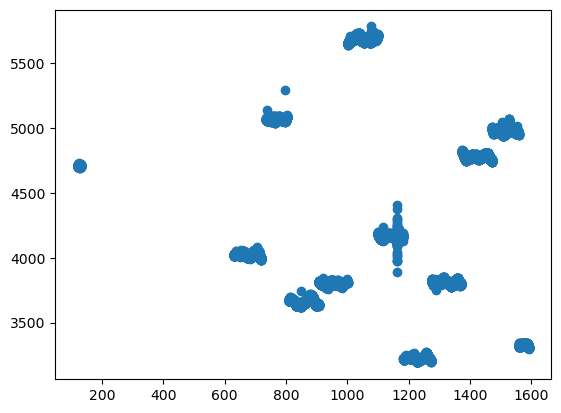

In [8]:
object_index = 0
df = dfs[object_index].reset_index(drop=True)
plt.scatter(df['time'],df['cbv flux'])

In [9]:
object_index = 0
diff = np.diff(df['time'])
args = np.argsort(diff)
sort_cadence =  args[~np.isnan(diff[args])][::-1]

dfs[object_index] = dfs[object_index].iloc[sort_cadence[0]+1:]
dfs[object_index].reset_index(drop=True,inplace=True)

## Drop first part in 8946433

In [10]:
diff = np.diff(df['time'][df['mask']])
args = np.argsort(diff)
sort_cadence =  args[~np.isnan(diff[args])][::-1]
start_index = df[df['mask']].index[sort_cadence[0]+1]

In [11]:
dfs[object_index] = dfs[object_index].iloc[start_index:]
dfs[object_index].reset_index(drop=True,inplace=True)

# Reduction

In [12]:
df

,time,cadenceno,flux,flux err,cbv flux,raw flux,raw flux err,quality,thermal recovery,mask,quarter
0,120.539646,568,5831.9873,4.518427,4712.456043,4706.3650,3.655198,0,True,True,0
1,120.560081,569,5823.8870,4.531149,4708.258881,4702.3670,3.654709,0,True,True,0
2,120.580515,570,5823.1064,4.525910,4706.405175,4700.4927,3.654733,0,True,True,0
3,120.600950,571,5832.5500,4.535167,4713.495661,4707.6494,3.655279,0,True,True,0
4,120.621385,572,5828.3867,4.524905,4709.258677,4703.3530,3.655239,0,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...
45981,1590.920156,72527,5096.8413,3.954076,3314.760299,3353.7140,2.585564,0,True,True,17
45982,1590.940591,72528,5078.2705,3.952691,3305.758870,3344.8262,2.584472,0,True,True,17
45983,1590.961026,72529,5094.3477,3.951653,3303.243897,3342.8552,2.584305,0,True,True,17
45984,1590.981460,72530,5075.4360,3.932071,3298.306143,3340.4230,2.583962,0,True,True,17


(6.0, 18.0)

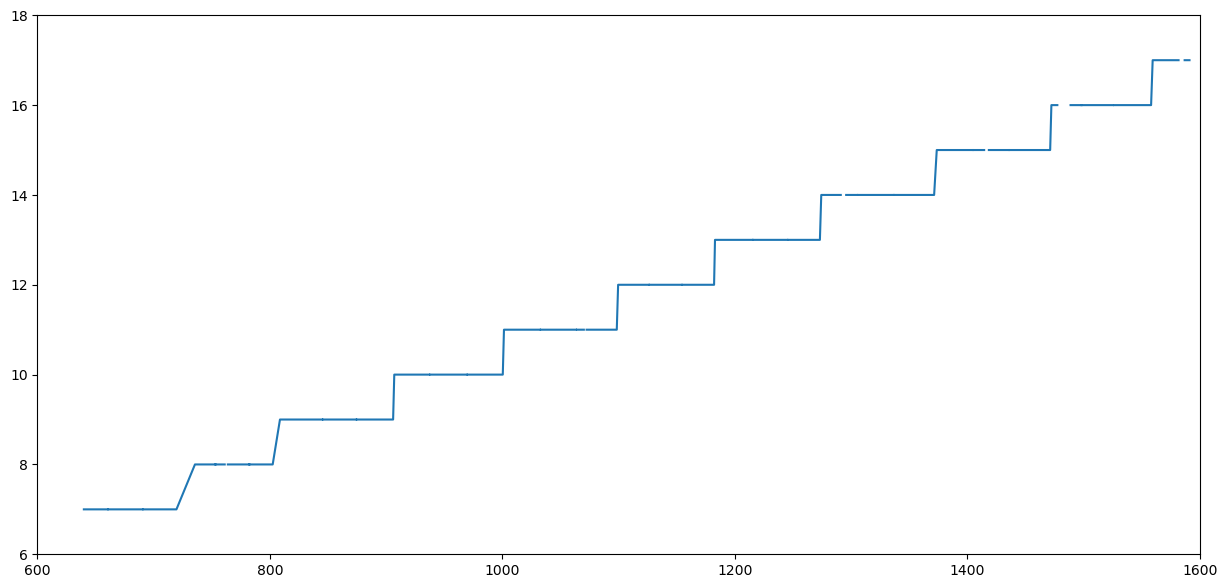

In [13]:
index = 0
df = dfs[index]

fig,ax = plt.subplots(figsize=(15,7))

plt.plot(df['time'],df['quarter'])
ax.set_xlim(600,1600)
ax.set_ylim(6,18)

In [14]:
q = np.round(np.diff(df['time'][~df['mask']]) / (df['time'].iloc[1]-df['time'].iloc[0]))
q = q[~np.isnan(q)]
q.sort()

In [15]:
counts,bins = np.histogram(q,bins = np.arange(1,100),density=True)
bins = bins[:np.where(counts)[0][-1]+1]
counts = counts[:np.where(counts)[0][-1]+1]

In [16]:
exp_fit = scipy.stats.expon.fit(q[(q>1) & (q<100)],floc=1)

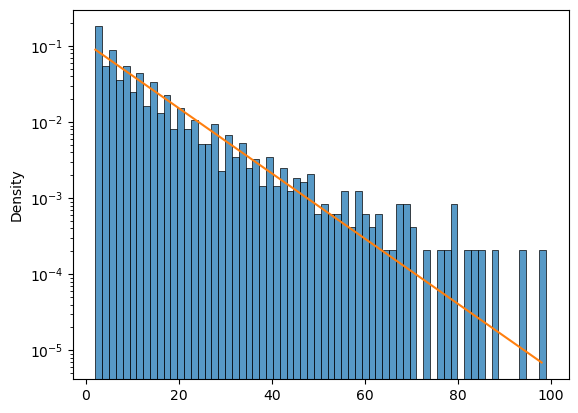

In [17]:
sns.histplot(q[(q>1) & (q<100)],stat='density')
plt.plot(bins[1:],scipy.stats.expon.pdf(bins[1:],*exp_fit),color='C1')
plt.yscale('log')

<AxesSubplot:ylabel='Count'>

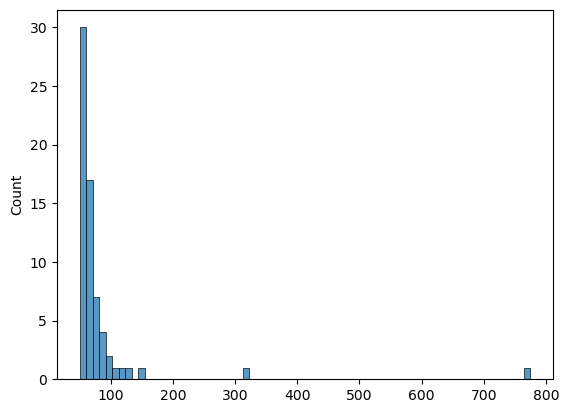

In [18]:
sns.histplot(q[q>=50])

In [19]:
q.min()

1.0

In [20]:
df.index

RangeIndex(start=0, stop=45034, step=1)

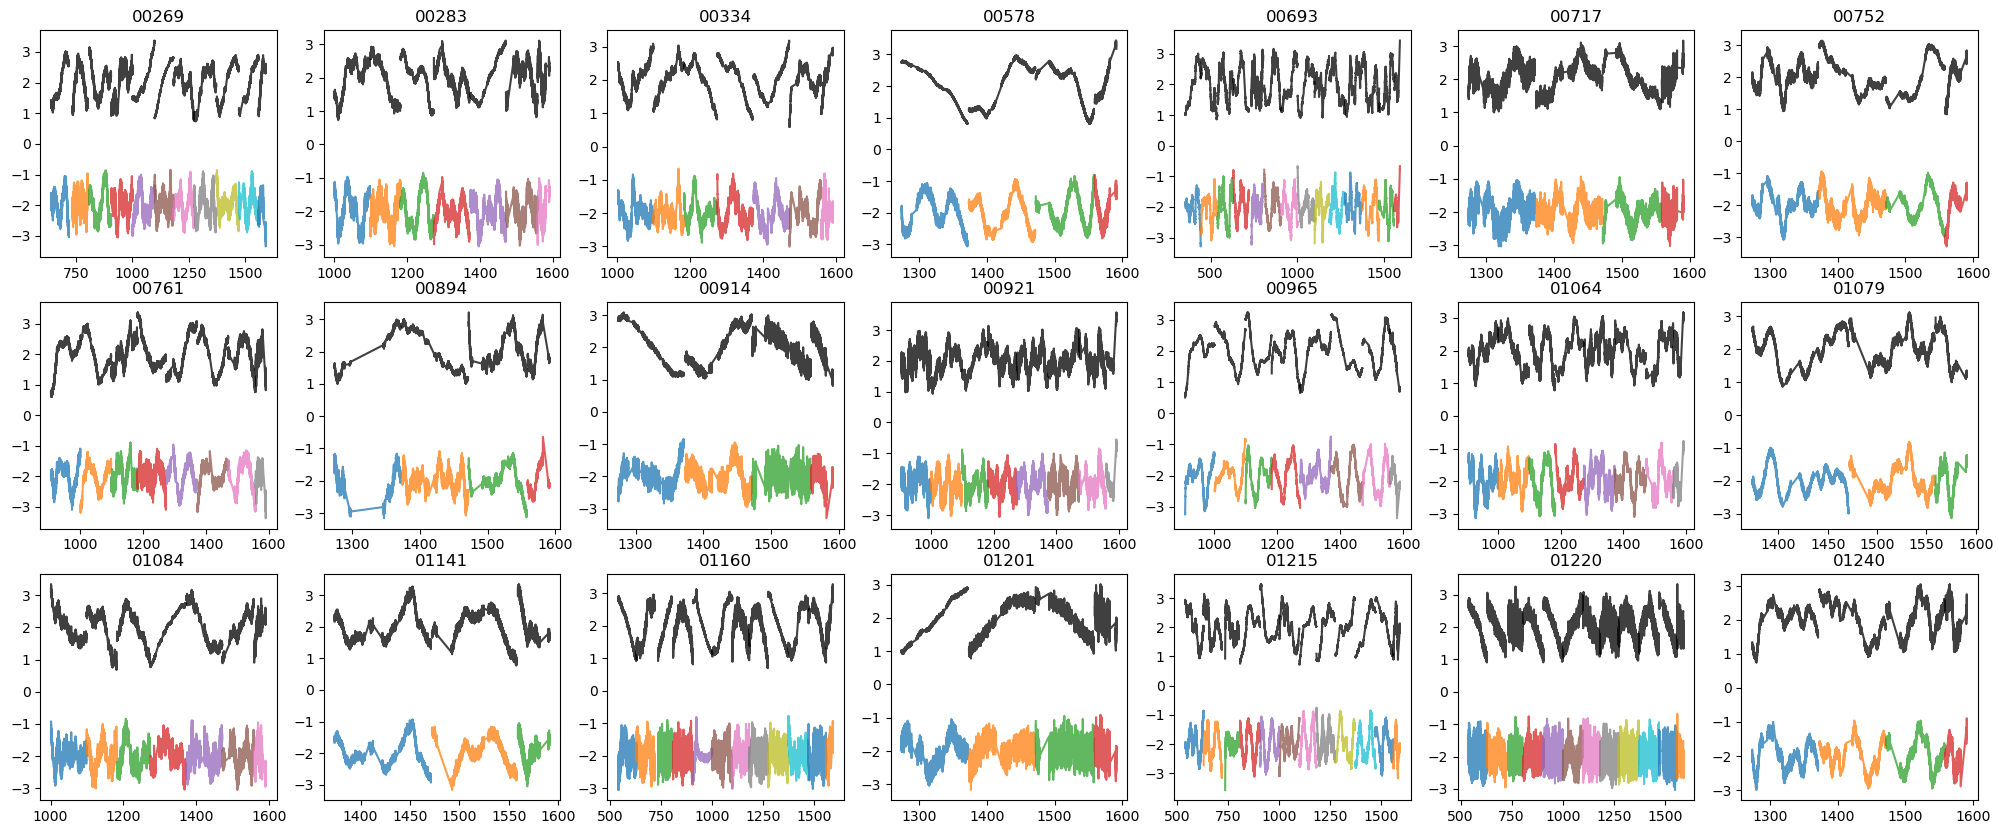

In [21]:
from copy import deepcopy
fig,ax = plt.subplots(3,7,figsize=(25,10))

def normalise(curve):
    curve/=0.5*(curve.max()-curve.min())
    curve-=curve.mean()
    return curve

for i in range(3):
    for j in range(7):

        index = 7*i+j
        df = dfs[index]

        mask = df['mask'].values

        for quarter in np.unique(df['quarter']):

            quarter_mask = (df['quarter']==quarter) & mask
            raw_vals = normalise(deepcopy(df['raw flux'][quarter_mask]))
            cbv_vals = normalise(deepcopy(df['cbv flux'][quarter_mask]))
            pdc_vals = normalise(deepcopy(df['flux'][quarter_mask]))

            ax[i,j].plot(df['time'][quarter_mask],raw_vals-raw_vals.mean()+2,color='k',alpha=0.75,label='Raw')
            ax[i,j].plot(df['time'][quarter_mask],cbv_vals-cbv_vals.mean()-2,alpha=0.75,label='Reduced by me')


        ax[i,j].set_title(names[index][:-4])
#ax[0,0].legend()

# Spline dfs

In [22]:
q = pd.concat(dfs)
time_step = np.nanmedian(np.diff(q['time']))
q = None

In [23]:
index = 0

df= dfs[index]
time_step = np.nanmedian(np.diff(df['time']))
grid = np.arange(df['time'][df['mask']].min(),df['time'][df['mask']].max()+time_step,time_step)
time_idx = np.round((df['time'][df['mask']]-df['time'][df['mask']].min())/time_step).astype(int)

In [24]:
quarters = np.unique(df[df['mask']]['quarter'])

In [25]:
from scipy.interpolate import BSpline

quarter_mask = df['mask'] & (df['quarter']==quarters[1])
spline_degree = 1
spliner = BSpline(np.pad(df['time'][quarter_mask],(spline_degree,spline_degree),'edge'),
                         np.pad(df['cbv flux'][quarter_mask],(0,spline_degree+1),'edge'), spline_degree, extrapolate=False)

spline_local = np.zeros_like(grid) * np.nan
spline_local[time_idx[df['mask']]] = spliner(grid[time_idx[df['mask']]])

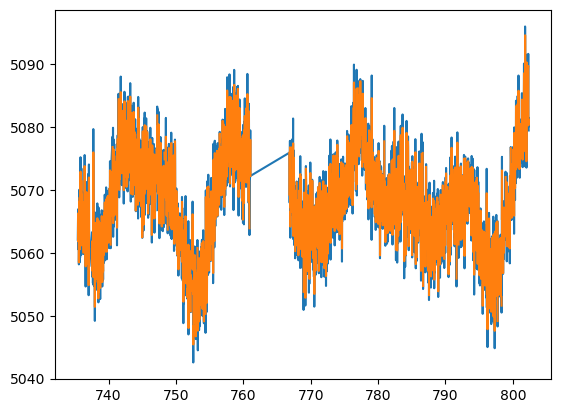

In [27]:
plt.plot(df['time'][quarter_mask],df['cbv flux'][quarter_mask])
plt.plot(grid,spline_local)

# Добавить сюда ошибку измерения чтобы я мог ее варьировать для спектра

In [37]:
spline_dfs = []
spectra_dfs = []

for index,name in enumerate(names):
    df= dfs[index]
    time_step = np.nanmedian(np.diff(df['time']))
    grid = np.arange(df['time'][df['mask']].min(),df['time'][df['mask']].max()+time_step,time_step)
    time_idx = np.round((df['time'][df['mask']]-df['time'][df['mask']].min())/time_step).astype(int)
    spline = np.zeros_like(grid)*np.nan
    quarter_num = np.zeros_like(grid)*np.nan
    quality = np.zeros_like(grid)
    full_time_idx = np.round((df['time']-df['time'][df['mask']].min())/time_step)
    quality[full_time_idx[~np.isnan(full_time_idx)].astype(int)] = df['quality'][~np.isnan(full_time_idx)]

    freqs = []
    spectra = []
    quarter_spec_num = []

    for quarter in np.unique(df[df['mask']]['quarter']):
        quarter_mask = df['mask'] & (df['quarter']==quarter)
        if quarter_mask.sum()==0:
            continue
        spline_degree = 1
        spliner = BSpline(np.pad(df['time'][quarter_mask],(spline_degree,spline_degree),'edge'),
                         np.pad(df['cbv flux'][quarter_mask],(0,spline_degree+1),'edge'), spline_degree, extrapolate=False)

        quarter_spline = np.zeros_like(grid) * np.nan
        quarter_spline[time_idx[df['mask']]] = spliner(grid[time_idx[df['mask']]])


        time = grid[time_idx[(df['quarter']==quarter)]]
        light = np.interp(time,grid[~np.isnan(quarter_spline)],quarter_spline[~np.isnan(quarter_spline)])
        freq = np.fft.rfftfreq(len(time),np.diff(time)[0])
        spec = np.abs(np.fft.rfft(light))**2

        freqs+=[freq]
        spectra+=[spec]
        quarter_spec_num+=[np.ones_like(spec)*quarter]


        spline[~np.isnan(quarter_spline)] = quarter_spline[~np.isnan(quarter_spline)]
        quarter_num[~np.isnan(quarter_spline)] = quarter




    spline_dfs.append(pd.DataFrame(np.stack([grid,spline,quarter_num,quality]).T,columns=['time','spline','quarter','quality']))
    spectra_dfs.append(pd.DataFrame(np.stack([np.concatenate(freqs),np.concatenate(spectra),np.concatenate(quarter_spec_num)]).T,
                                    columns=['freq','power','quarter']))

/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


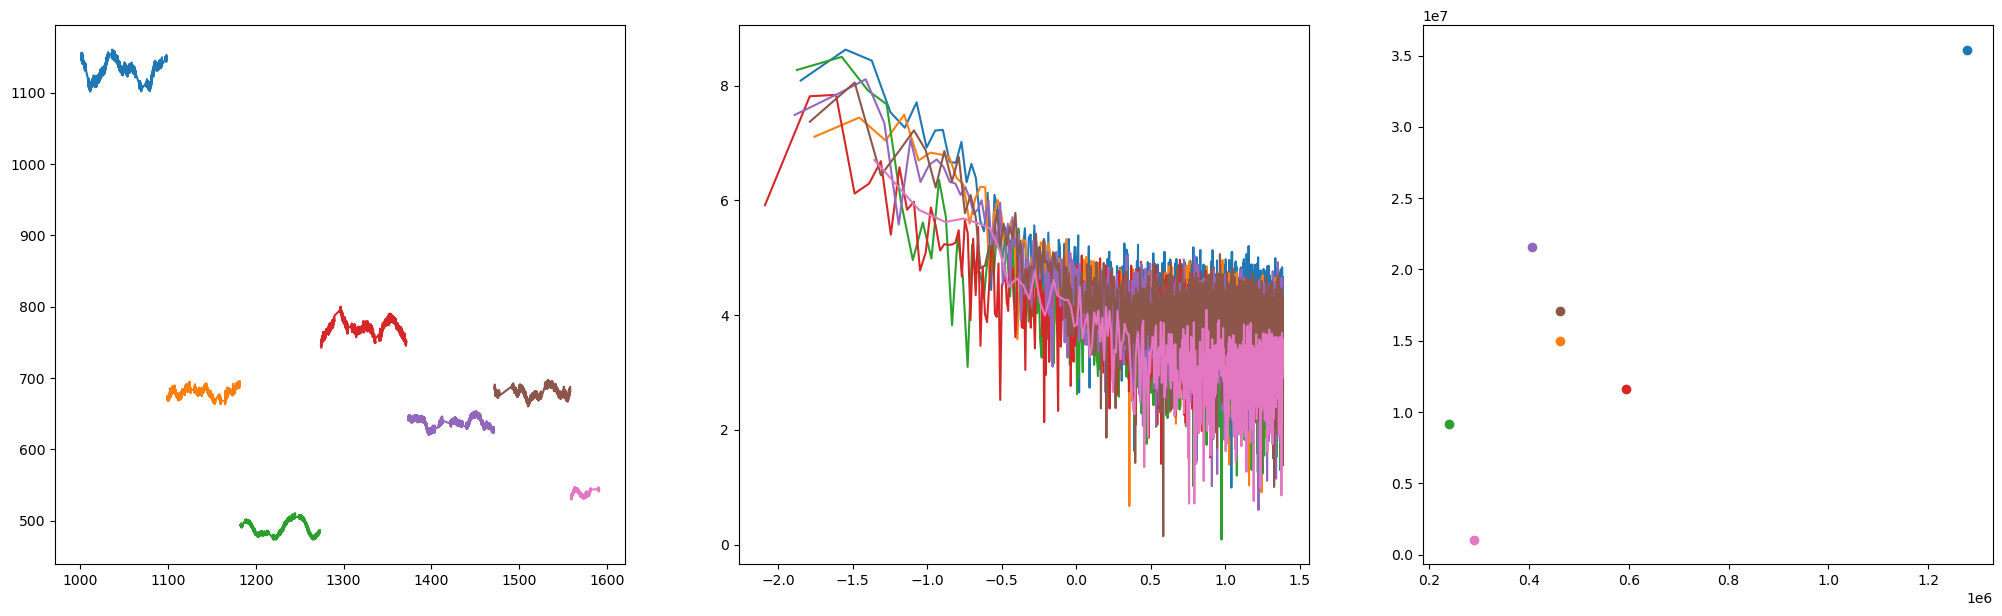

In [66]:
index=1
df = spline_dfs[index]
df_spec = spectra_dfs[index]
fig,ax = plt.subplots(1,3,figsize=(25,7))
for quarter in np.unique(df['quarter']):
    time = df['time'][df['quarter']==quarter]
    light = df['spline'][df['quarter']==quarter]
    freq = df_spec['freq'][df_spec['quarter']==quarter]
    power = df_spec['power'][df_spec['quarter']==quarter]
    ax[0].plot(time,light)
    ax[1].plot(np.log10(freq),np.log10(power))
    ax[2].scatter(light.mean()**2,power[freq>1].sum())

/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


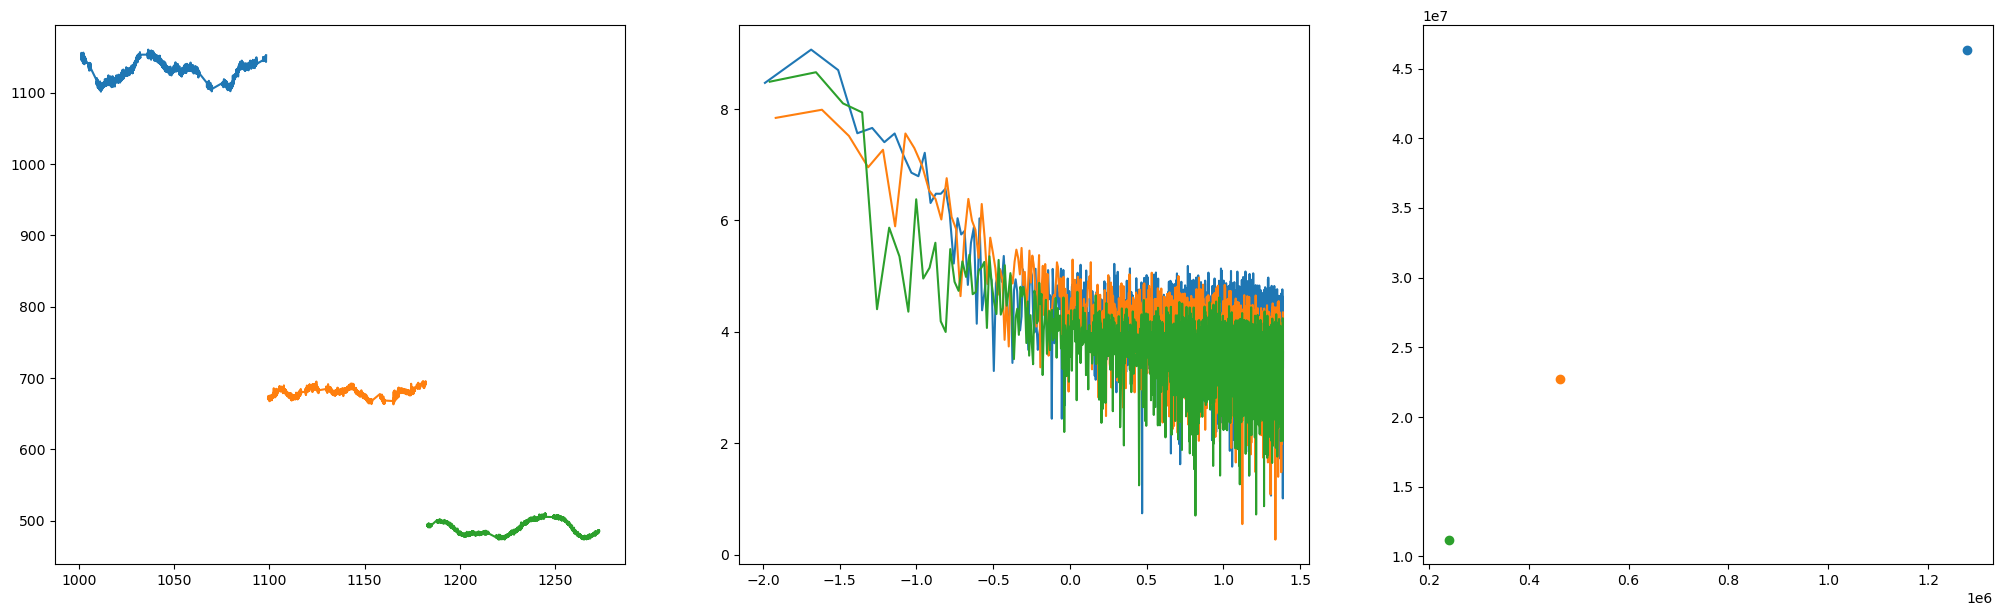

In [179]:

fig,ax = plt.subplots(1,3,figsize=(25,7))
for quarter in np.unique(df['quarter'])[:3]:
    time = df['time'][df['quarter']==quarter]
    light = df['spline'][df['quarter']==quarter]
    freq = df_spec['freq'][df_spec['quarter']==quarter]
    power = df_spec['power'][df_spec['quarter']==quarter]
    ax[0].plot(time,light)
    ax[1].plot(np.log10(freq),np.log10(power))
    ax[2].scatter(light.mean()**2,power[freq>1].sum())

In [38]:
index=1
df = spline_dfs[index]
add_coefs = np.zeros_like(df['time'])
mult_coefs = np.ones_like(df['time'])
num_cadence = 10

total_sum = 0
total_prod = 1

for quarter_1,quarter_2 in zip(np.unique(df['quarter'])[:-1],np.unique(df['quarter'])[1:]):
    light_1 = df['spline'][df['quarter']==quarter_1]
    light_2 = df['spline'][df['quarter']==quarter_2]

    additive_coef =  light_1[-num_cadence:].mean() - light_2[:num_cadence].mean()
    total_sum += additive_coef
    add_coefs[df['quarter']==quarter_2] = total_sum
    mult_coef =  light_1[-num_cadence:].mean() / light_2[:num_cadence].mean()
    total_prod *= mult_coef
    mult_coefs[df['quarter']==quarter_2] = total_prod

In [68]:
mult_coefs

array([1.        , 1.        , 1.        , ..., 2.11919839, 2.11919839,
       1.        ])

/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


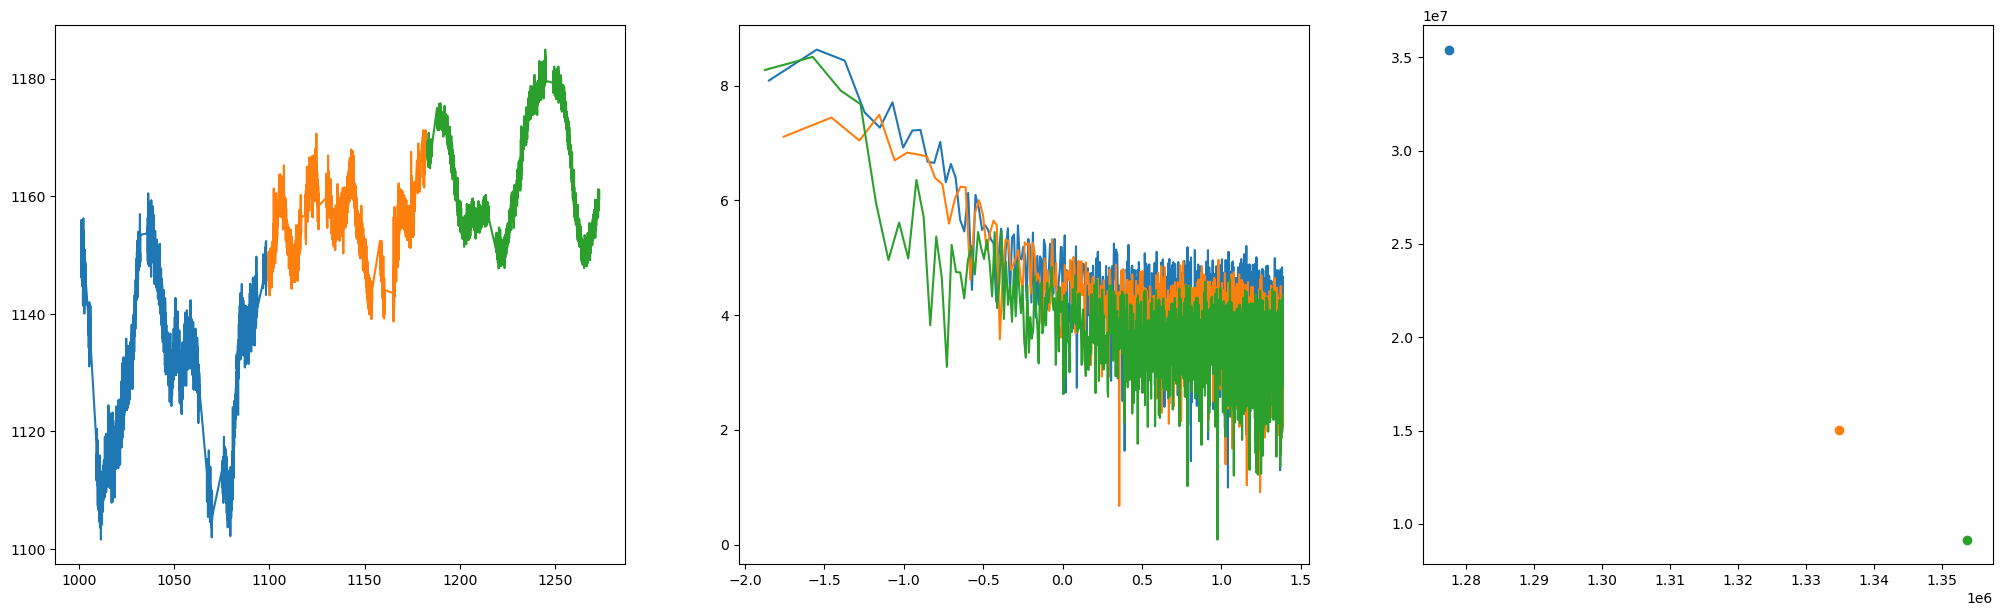

In [69]:
fig,ax = plt.subplots(1,3,figsize=(25,7))
for quarter in np.unique(df['quarter'])[:3]:
    time = df['time'][df['quarter']==quarter]
    light = (df['spline'] + add_coefs)[df['quarter']==quarter]
    freq = df_spec['freq'][df_spec['quarter']==quarter]
    power = df_spec['power'][df_spec['quarter']==quarter]
    ax[0].plot(time,light)
    ax[1].plot(np.log10(freq),np.log10(power))
    ax[2].scatter(light.mean()**2,power[freq>1].sum())

/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


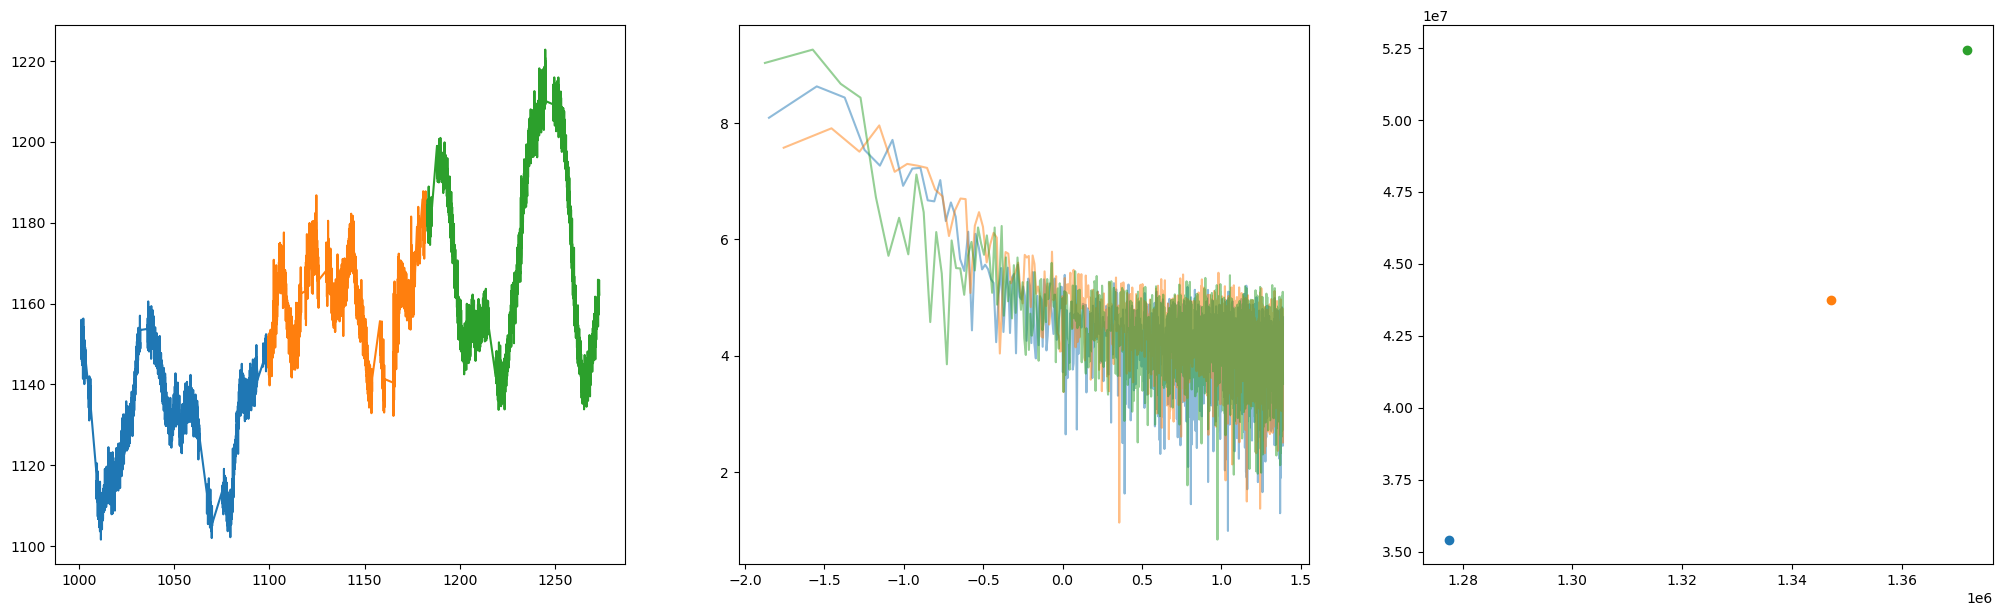

In [70]:
fig,ax = plt.subplots(1,3,figsize=(25,7))
for quarter in np.unique(df['quarter'])[:3]:
    time = df['time'][df['quarter']==quarter]
    light = (df['spline'] * mult_coefs)[df['quarter']==quarter]
    freq = df_spec['freq'][df_spec['quarter']==quarter]
    power = (df_spec['power'][df_spec['quarter']==quarter])*(np.unique(mult_coefs[df['quarter']==quarter])[0])**2
    ax[0].plot(time,light)
    ax[1].plot(np.log10(freq),np.log10(power),alpha=0.5)
    ax[2].scatter(light.mean()**2,power[freq>1].sum())

In [39]:
for index,name in enumerate(names):
    df = spline_dfs[index]
    df_spec = spectra_dfs[index]
    add_coefs = np.zeros_like(df['time'])
    mult_coefs = np.ones_like(df['time'])
    df_spec['power_mult'] = deepcopy(df_spec['power'])
    num_cadence = 10

    total_sum = 0
    total_prod = 1

    for quarter_1,quarter_2 in zip(np.unique(df['quarter'])[:-1],np.unique(df['quarter'])[1:]):
        light_1 = df['spline'][df['quarter']==quarter_1]
        light_2 = df['spline'][df['quarter']==quarter_2]

        additive_coef =  light_1[-num_cadence:].mean() - light_2[:num_cadence].mean()
        total_sum += additive_coef
        add_coefs[df['quarter']==quarter_2] = total_sum
        mult_coef =  light_1[-num_cadence:].mean() / light_2[:num_cadence].mean()
        total_prod *= mult_coef
        mult_coefs[df['quarter']==quarter_2] = total_prod

        df_spec['power_mult'][df_spec['quarter']==quarter_2] *= total_prod**2

    df['additive_stich'] = add_coefs
    df['multiplicative_stich'] = mult_coefs



/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


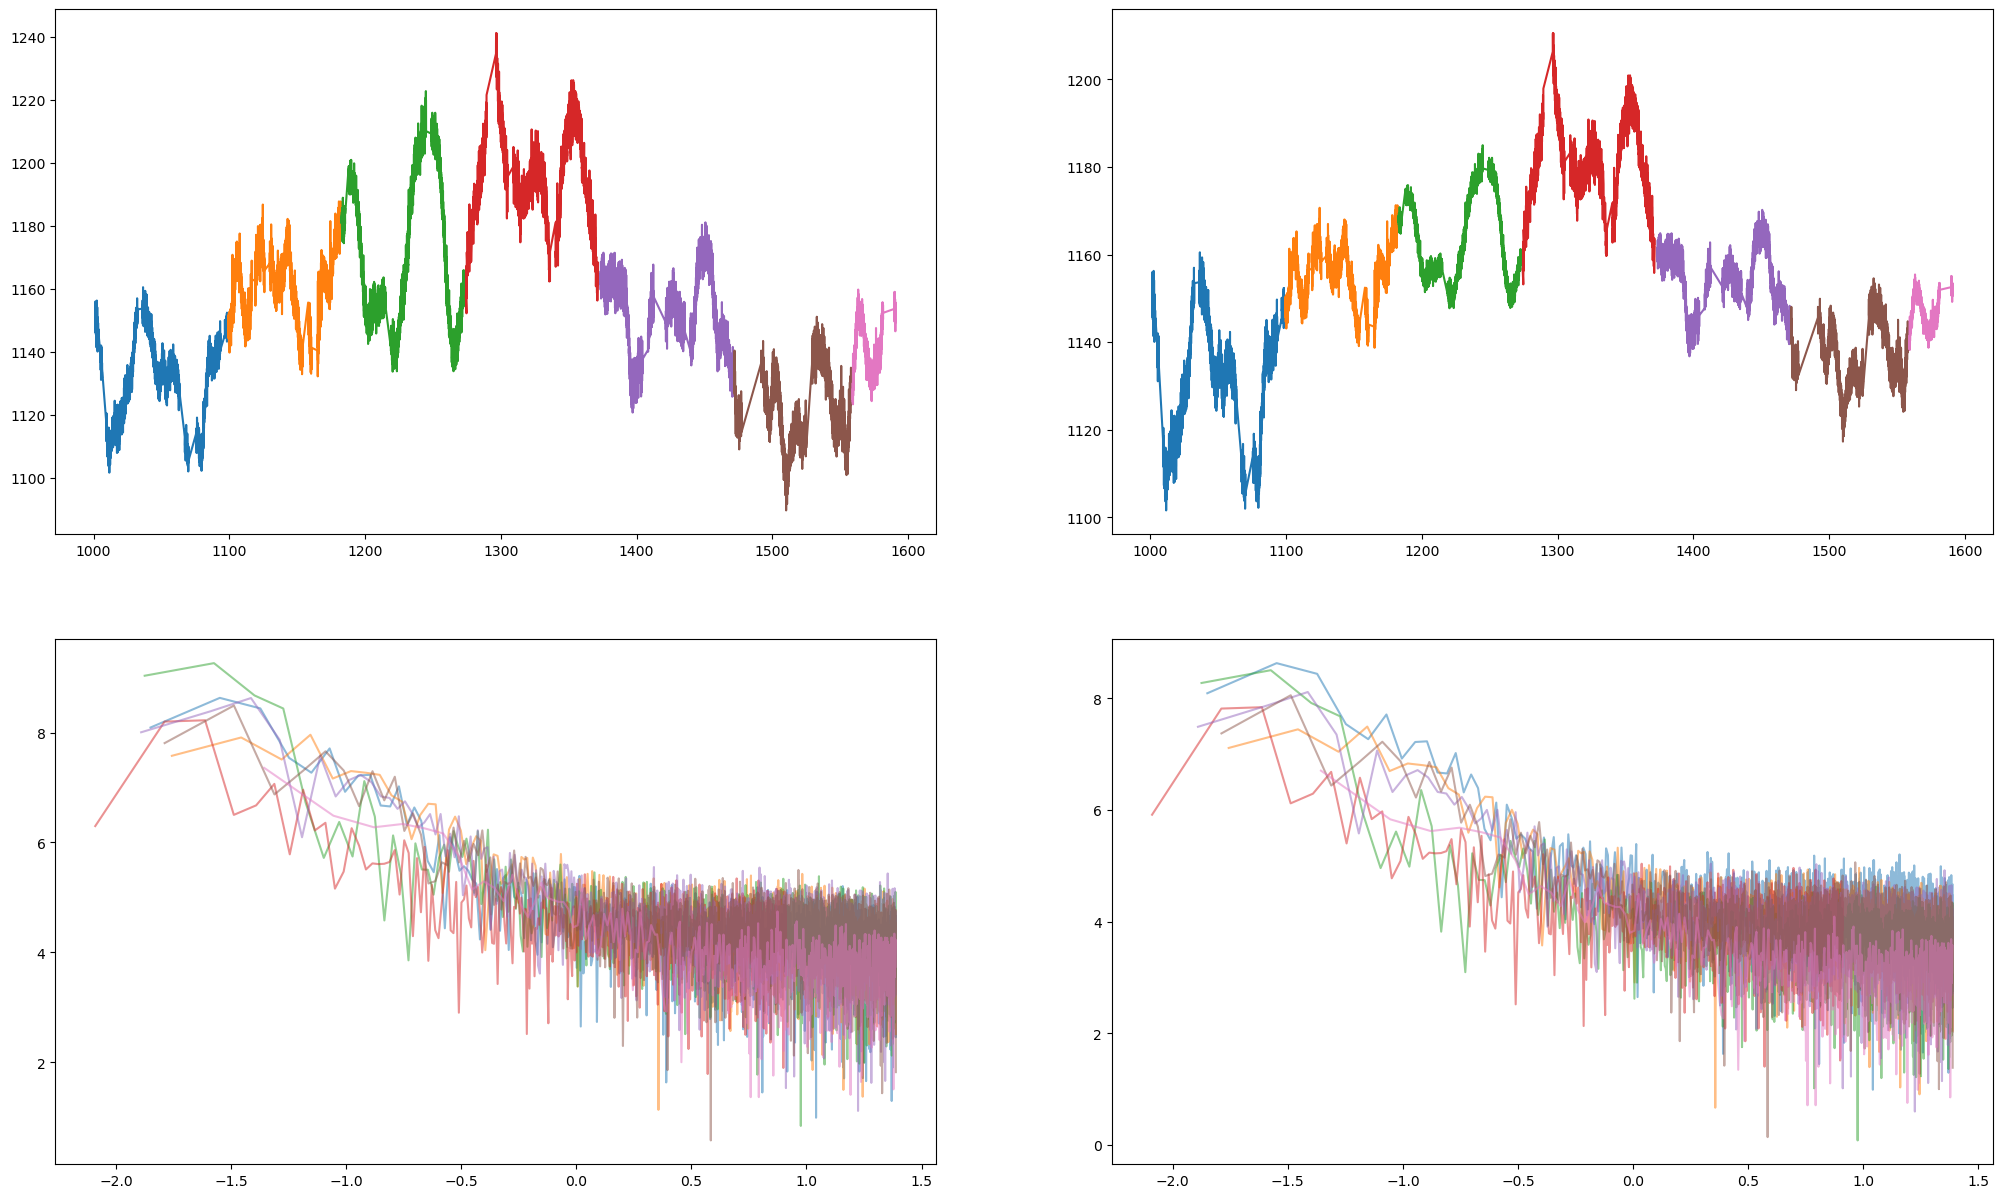

In [35]:
index=1
df = spline_dfs[index]
df_spec = spectra_dfs[index]
fig,ax = plt.subplots(2,2,figsize=(25,15))
for quarter in np.unique(df['quarter']):
    time = df['time'][df['quarter']==quarter]
    light_add = (df['spline']+df['additive_stich'])[df['quarter']==quarter]
    light_mult = (df['spline']*df['multiplicative_stich'])[df['quarter']==quarter]
    freq = df_spec['freq'][df_spec['quarter']==quarter]
    power = df_spec['power'][df_spec['quarter']==quarter]
    power_mult = df_spec['power_mult'][df_spec['quarter']==quarter]
    ax[0,0].plot(time,light_mult)
    ax[0,1].plot(time,light_add)
    ax[1,0].plot(np.log10(freq),np.log10(power_mult),alpha=0.5)
    ax[1,1].plot(np.log10(freq),np.log10(power),alpha=0.5)

009650712


/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


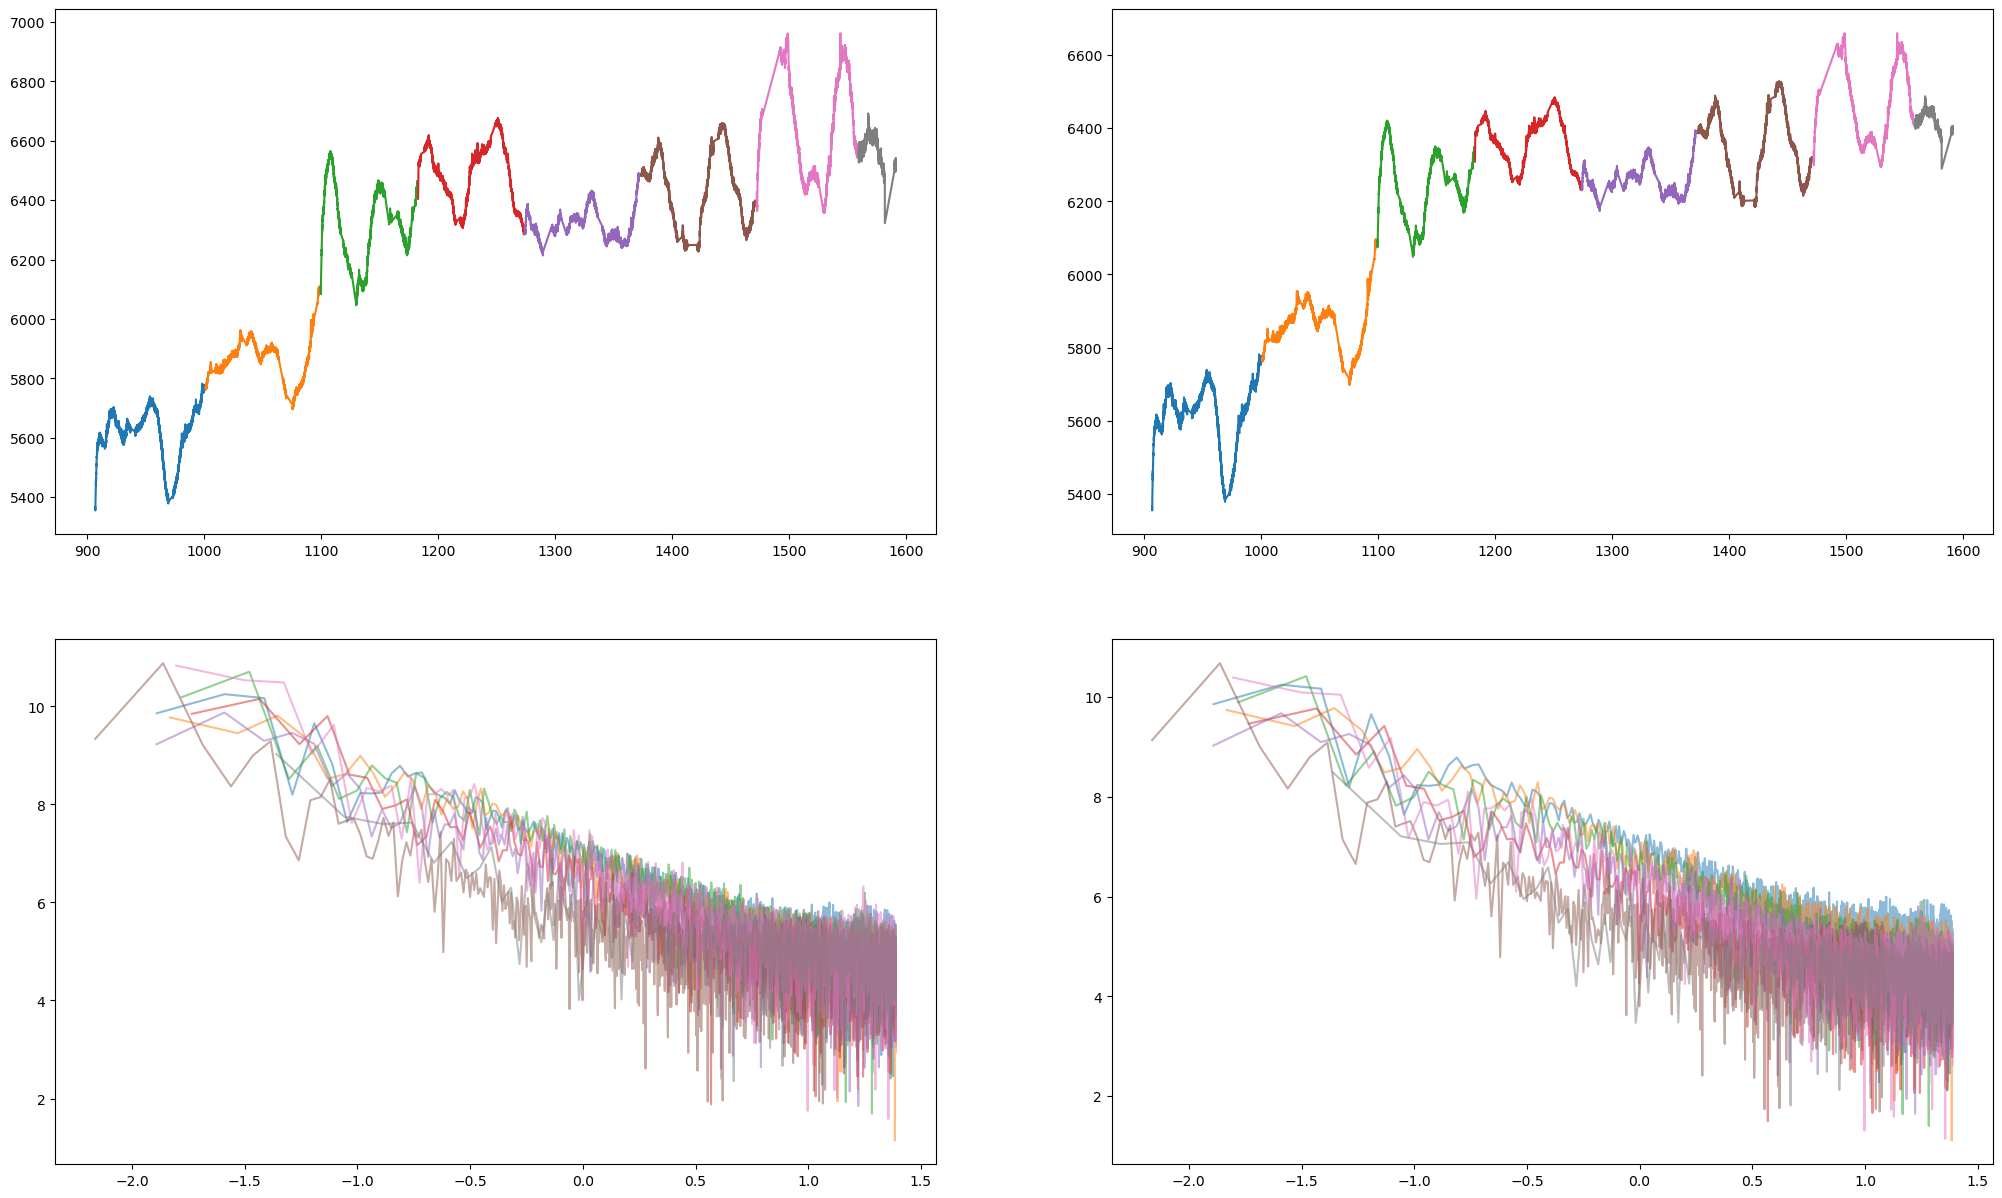

In [36]:
index=11
print(names[index])
df = spline_dfs[index]
df_spec = spectra_dfs[index]
fig,ax = plt.subplots(2,2,figsize=(25,15))
for quarter in np.unique(df['quarter']):
    time = df['time'][df['quarter']==quarter]
    light_add = (df['spline']+df['additive_stich'])[df['quarter']==quarter]
    light_mult = (df['spline']*df['multiplicative_stich'])[df['quarter']==quarter]
    freq = df_spec['freq'][df_spec['quarter']==quarter]
    power = df_spec['power'][df_spec['quarter']==quarter]
    power_mult = df_spec['power_mult'][df_spec['quarter']==quarter]
    ax[0,0].plot(time,light_mult)
    ax[0,1].plot(time,light_add)
    ax[1,0].plot(np.log10(freq),np.log10(power_mult),alpha=0.5)
    ax[1,1].plot(np.log10(freq),np.log10(power),alpha=0.5)

In [40]:
!ls

CBVs                      Overview.ipynb            light_curves_CBV_corr_1
Curve_stiching.ipynb      kepcotrend.log            light_curves_CBV_corr_2
Curve_stiching_base.ipynb legacy_analysis           reduced_light_curves
Data_reduction.ipynb      light_curves
MCMC_chains               light_curves_CBV_corr


In [41]:
!ls ../../data/Kepler

002694186.csv 007175757.csv 009215110.csv 011413175.csv 012401487.csv
002837332.csv 007523720.csv 009650712.csv 011606854.csv
003347632.csv 007610713.csv 010645722.csv 012010193.csv
005781475.csv 008946433.csv 010798894.csv 012158940.csv
006932990.csv 009145961.csv 010841941.csv 012208602.csv


In [42]:
from pathlib import Path
filepath = '../../data/Kepler/'
Path(filepath).mkdir(parents=True,exist_ok=True)

In [45]:
for object_index,name in enumerate(names):
    df_orig = spline_dfs[object_index]
    df = pd.DataFrame(np.stack([df_orig['time'],df_orig['spline']*df_orig['multiplicative_stich'],
                                df_orig['quarter'],df_orig['quality'],df_orig['spline']]).T,
                  columns=['time','light','quarter','quality','raw light'])
    df.to_csv(filepath+str(name)+'.csv')